# Customer Churn Prediction

Vincent Luong

## Introduction: Predicting Customer Churn in Subscription-Based Services

In recent years, monthly subscription-based services have surged in popularity, spanning industries such as streaming (e.g., Netflix, Spotify), SaaS (Software as a Service), fitness (e.g., Peloton), and e-commerce (e.g., Amazon Prime). These models offer convenience and consistent revenue streams, making them an attractive business strategy. However, they also introduce a critical metric to monitor: **customer churn**.

**Customer Churn**: refers to the percentage of customers who cancel or stop renewing their subcriptions during a given time period.  High churn rates can significantlyt impact revenue and long-term growth, especially in competitive markets wjere acquiring new customers is often more expenstive then retaining existing ones.

To mitigate churn and retain consumers, we can implement strategies such as:
- Personalized offers and retention campaigns
- Improving onboarding and customer support
- Monitoring engagement metrics to intervene before customers churn

To stay ahead of potential losses, we can utilize data-driven churn prediction models that help us act proactively rather than reactively. These models analyze customer behavior and identify individuals who are at a high risk of leaving, allowing companies to intervene before it’s too late. Common machine learning approaches used for predicting churn include:
- **Logistic Regression**: A simple and interpretable baseline model for binary classification
- **Decision Trees and Random Forests**: Useful for capturing nonlinear patterns and feature importance
- **Gradient Boosting Machines**: Models such as XGBoost and LightGBM are power ensemble methods with strong predictive performance
- **Neural Networks**: Applied for complex. high-dimensional data scenarios
- **Survival Analysis**: Useful when modeling when a customer will churn, not just if.

In this project, we aim to develop a machine learning model to predict whether a customer is likely to churn based on historical subscription and behavioral data introduced below. This prediction can empower businesses to make informed decisions that reduce churn and enhance customer lifetime value.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data

The [Telco Customer Churn dataset 11.1.3+](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data), originally provided by IBM and hosted on Kaggle, offers detailed information about a telecommunications company's customers and their subscription behavior. It contains 7,043 customer records with 33 features, covering demographics, account details, and service usage patterns. The dataset has been updated to include more comprehensive information, providing deeper insights into customer behavior and churn factors.

Features Include:

🔑 Identifiers & Location
1. `customerID`: A unique ID that identifies each customer
2. `Count`: A value used in reporting/dashboarding to sum up the number of customers in a filtered set
3. `Country`: The country of the customer's primary residence
4. `State`: The state of hte customer's primary residence
5. `City`: The city of hte customer's primary residence
6. `Zip Code`: The zip code of the customer's primary residence
7. `Lat Long`: The combined latitude and longitude of the customer's primary residence
8. `Lattitude`: The latitude of the customer's primary residence
9. `Longitude`: The longitude of the customer's primary residence
    
👤 Demographics
1. `Gender`: The gender of a customer
2. `SeniorCitizen`: A binary variable indicating whether the customer is a senior citizen or not (0 or 1)
3. `Partner`: Whether the customer has a partner or not (True or False)
4. `Dependents`: Whether the customer has dependents or not (Yes or No)
   
⏳ Customer Tenure
1. `tenure`:  Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above

📞 Services Subscribed
1. `PhoneService`: Indicates if the customer subscribes to home phone service with the company (Yes, No)
2. `MultipleLines`:  Indicates if the customer subscribes to multiple telephone lines with the company (Yes, No)
3. `InternetService`: Indicates if the customer subscribes to Internet service with the company (No, DSL, Fiber Optic, Cable)
4. `OnlineSecurity`: Indicates if the customer subscribes to an additional online security service provided by the company (Yes, No)
5. `OnlineBackup`: Indicates if the customer subscribes to an additional online backup service provided by the company (Yes, No)
6. `Device Protection`: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company (Yes, No)
7. `Tech Support`: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times (Yes, No)
8. `Streaming TV`: Indicates if the customer uses their Internet service to stream television programing from a third party provider (Yes, No, The company does not charge an additional fee for this service)
9. `Streaming Movies`: Indicates if the customer uses their Internet service to stream movies from a third party provider (Yes, No, The company does not charge an additional fee for this service)

💳 Billing & Payment
1. `Contract`: Indicates the customer’s current contract type (Month-to-Month, One Year, Two Year)
2. `Paperless Billing`: Indicates if the customer has chosen paperless billing (Yes, No)
3. `Payment Method`: Indicates how the customer pays their bill (Bank Withdrawal, Credit Card, Mailed Check)
4. `Monthly Charge`: Indicates the customer’s current total monthly charge for all their services from the company.
5. `Total Charges`: Indicates the customer's total charges, calulated to the end of the quarter specified above.

🔍 Churn-Related Information
1. `Churn Label`: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.
2. `Churn Value`: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.
3. `Churn Score`: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.
4. `CLTV`: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.
5. `Churn Reason`:  A customer’s specific reason for leaving the company. Directly related to Churn Category.

In [2]:
con_dat = pd.read_excel('data/Telco_customer_churn_recent.xlsx')
con_dat.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


From the dataset above, we observe that the columns `Churn Label` and `Churn Value` are directly correlated, with a one-to-one relationship. Including both as target variables would introduce redundancy and could lead to artificially inflated model performance. To avoid this, we will remove `Churn Label` and use only `Churn Value` as our target variable during the train/test split.

## Explanatory Data Analysis

**Exploratory Data Analysis** (EDA) is the process of investigating and summarizing the key characteristics of a dataset before applying any modeling techniques. It helps uncover patterns, spot anomalies, identify missing values, test assumptions, and gain insights into the structure of the data. Through visualizations and statistical summaries, EDA allows us to help make informed data-driven decisions about data cleaning, feature engineering, and model selection, ensuring that the data is well-understood and ready for analysis.

### Data Shape and Data Types

Below, we examine the structure of the dataset by displaying its shape, which includes the number of rows and columns, as well as the data types of each feature. This helps us understand what kind of preprocessing may be required.

In [3]:
con_dat.shape

(7043, 33)

In [4]:
con_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

#### Missing Values

We will analyze missing values to ensure the quality and reliability of our data before performing any analysis or building predictive models.  Missing values can lead to biased results, reduce model accuracy, and cause errors during processing. Identifying and handling them appropriately helps maintain the integrity of the dataset and ensures that the insights or predictions we generate are based on complete and meaningful information.

In [5]:
con_dat.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

From the dataset, we observe some **non-response bias**, as certain customers did not provide a reason for why they churned. Aside from this, the remaining features appear relatively clean, with no missing values present.

#### Unique Features

Unique features help us better understand the structure and variability of our dataset.  Identifying the number of unique values in each feature helps determine whether a feature is categorical, binary, or continuous, and whether its suitable for analysis or modeling.  It also helps us detect potential issues such as constant columns with no variability, which provide little to no predictive power and may be removed.  Understanding uniqueness ensures we handle features appropriately during preprocessing and model training.

In [6]:
con_dat.select_dtypes(include='object').nunique()

CustomerID           7043
Country                 1
State                   1
City                 1129
Lat Long             1652
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Total Charges        6531
Churn Label             2
Churn Reason           20
dtype: int64

From the dataset above, we observe that both Country and State contain only a single unique value.  `Country` is "United States" and `State` is "California." This indicates that all customers are located in the same region. Since these features do not offer any variability, they are unlikely to contribute meaningful predictive power and can be safely dropped from the analysis.

Additionally, we see that`CustomerID` is the unique key for identifying a customer, thus meaning that our model prediction will not be affected by `CustomerID`, we can also remove this column below.

In [7]:
con_dat.drop(['CustomerID', 'Country', 'State'], axis=1, inplace=True)
con_dat.head()

,Count,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,1,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,1,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,1,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,1,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,1,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


### Churn Reasons Distributions

Beneath, we analyze the reasons why customers have churned in order to gain deeper insights that can help improve customer retention strategies.

In [8]:
con_dat['Churn Reason'].value_counts()

Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Limited range of services                     44
Long distance charges                         44
Lack of affordable download/upload speed      44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: Churn Reason, 

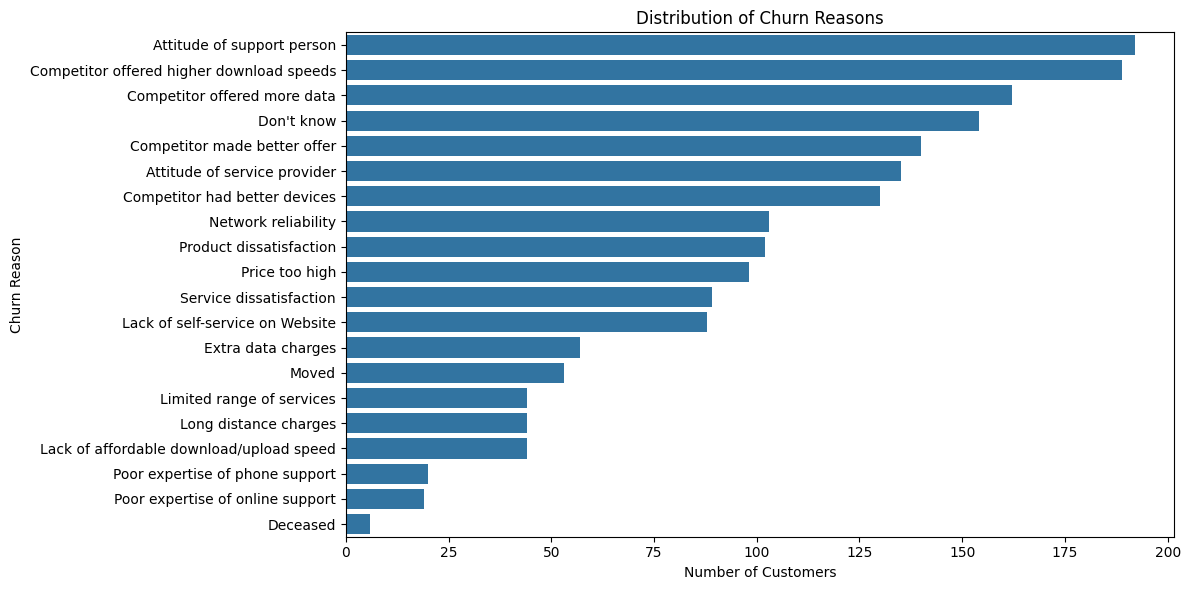

In [9]:
# Set figure size
plt.figure(figsize=(12, 6))

# Plot
sns.countplot(y='Churn Reason', data=con_dat, order=con_dat['Churn Reason'].value_counts().index)

# Add titles and labels
plt.title('Distribution of Churn Reasons')
plt.xlabel('Number of Customers')
plt.ylabel('Churn Reason')
plt.tight_layout()
plt.show()

From the visualizations above, we observe that many customers churn due to issues related to customer support and more attractive offers from competitors.

#### Summary Statistics

Below are the summary statistics about the dataset. These summary statistics provides a quick overview of the central tendency, spread, and distribution of numerical features. It helps identify outliers, anomalies, and potential data entry errors, such as unexpected negative values. Differences between metrics like the mean and median can reveal skewed distributions, which may require transformation before modeling. Summary statistics also allow for easy comparison between features, guiding decisions on normalization or feature scaling. Overall, this step ensures that you understand the structure and quality of your data before moving forward with analysis or modeling.

In [10]:
con_dat.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


### Data Visualization

#### Distribution of Churn Population

We visualize the distribution of the churn population as it helps us understand the balance between churned and retained customers, which is crucial for building effective predictive models.  If the dataset is imbalanced (e.g., many more non-churned than churned customers), it can bias the model toward the majority class, leading to misleading accuracy and poor performance in detecting actual churn. Visualization also provides an immediate, intuitive grasp of class proportions, helps guide decisions like resampling (oversampling or undersampling), and highlights whether churn is a significant concern for the business.

<Axes: xlabel='Churn Label', ylabel='count'>

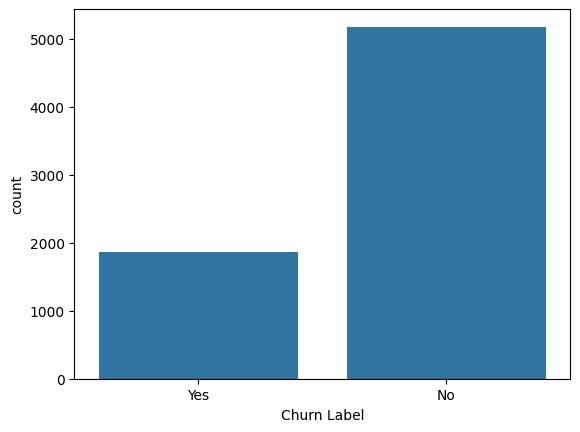

In [11]:
sns.countplot(x='Churn Label', data=con_dat)

From the graph above, we see that there appears some class imbalance in the dataset.  Since we observe class imbalance in the dataset, we need to take steps to ensure our model doesn't become biased toward the majority class. This imbalance can lead to misleading accuracy and poor performance in identifying actual churners. To address this, we can apply resampling techniques such as oversampling the minority class or undersampling the majority class. Additionally, we should use evaluation metrics like precision, recall, F1-score, and AUC rather than relying solely on accuracy. These steps will help create a more balanced and reliable churn prediction model.

### Distribution of Churn Population of Given Features

#### Distribution of Churn Population Given City

Below we will visualize the distribuion of how many customers churned based on the category we will first start by dispalying the top 10 cities:

In [24]:
# Get the top 10 cities by number of customers
top_10_cities = con_dat['City'].value_counts().head(10).index

# Filter the dataset to include only those top 10 cities
top_10_df = con_dat[con_dat['City'].isin(top_10_cities)]

# Preview the result
top_10_df['City'].value_counts()

Los Angeles      305
San Diego        150
San Jose         112
Sacramento       108
San Francisco    104
Fresno            64
Long Beach        60
Oakland           52
Stockton          44
Bakersfield       40
Name: City, dtype: int64

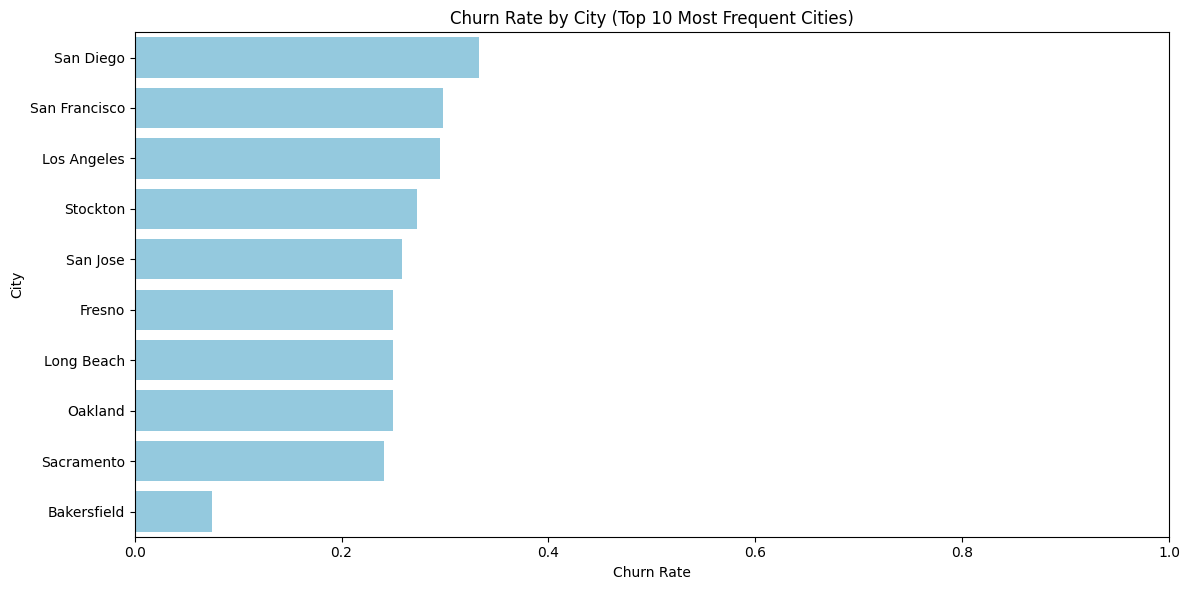

In [25]:
#churn rate by city
churn_rate_by_city = (
    top_10_df.groupby('City')['Churn Value']
    .mean()
    .sort_values(ascending=False)
)

#plot the charts
plt.figure(figsize=(12, 6))
sns.barplot(
    x=churn_rate_by_city.values,
    y=churn_rate_by_city.index,
    color='skyblue'
)
plt.title('Churn Rate by City (Top 10 Most Frequent Cities)')
plt.xlabel('Churn Rate')
plt.ylabel('City')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

From the top 10 most populated cities, we see that San Diego tends to have the highest churn rate.

### Data Cleaning

**Data Cleaning** is the process of identifying and correcting errors, inconsistencies, and inaccuracies in a dataset to improve its quality and ensure reliable analysis. This involves handling missing values, correcting data types, removing duplicate or irrelevant entries, standardizing formats, and resolving inconsistencies. Clean data is essential for building accurate and trustworthy models, as poor-quality data can lead to misleading insights and reduced model performance.

We will first split the data to prevent any **data-leakage** from occuring.  **Data Leakage** is the occurence when information from outside the training dataset unintentionally influences the model during training.  This can happen when preporcessing steps like scaling, encoding, or imputing are applied before the train-test split, or when target-related information is included in the features.  Data leakage leads to overly optimistic and overfitting results during evaluation; thus not generalizing well to real-world data and performance.

#### Data Train/Test Split Creation

We will be splitting the data into a 80/20 test split

In [12]:
from sklearn.model_selection import train_test_split

# Creating dataset with without target
X = con_dat.drop(['Churn Label', 'Churn Value'], axis=1)
# Creating dataset with target
y = con_dat['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

#### Churn Reason Imputing

In our **EDA**, we saw that for some of the reasons stated there appeared some non-response bias or unknown reasons for why customers have churned.  We will impute this also fit the category of "Don't know".

In [13]:
X_train['Churn Reason'].isna().sum()

4139

In [14]:
(X_train['Churn Reason'] == "Don't know").sum()

122

In [15]:
X_train['Churn Reason'].fillna("Don't know", inplace=True)
X_test['Churn Reason'].fillna("Don't know", inplace=True)

X_train['Churn Reason'].head()

3182    Don't know
753     Don't know
2686    Don't know
4855    Don't know
4452    Don't know
Name: Churn Reason, dtype: object

Imputing missing values in `Churn Reason` with "Don't know" is a practical approach that preserves all data, avoids model errors from NaN values, and maintains interpretability by clearly indicating that no reason was provided. It also prevents data leakage by applying imputation after splitting and may capture meaningful patterns; as customers who don’t provide a reason could behave differently from those who do.